In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
from sqlalchemy import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [5]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

#### Design a query to retrieve the last 12 months of precipitation data and plot the results, starting from the most recent data point in the database. 


In [8]:
last_date1 = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
last_date = (dt.datetime.strptime(last_date1, "%Y-%m-%d")).date()
print(last_date)

2017-08-23


In [9]:
yearago1_date = last_date - dt.timedelta(days=365)
print(yearago1_date)

2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= yearago1_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Select only the `date` and `prcp` values.
# Sort the dataframe by date

precip = pd.DataFrame(precip_data, columns = ["date", "prcp"]).sort_values(["date"])
precip.rename(columns={"prcp":"Precipitation", "date":"Date"}, inplace=True)
precip.set_index("Date", inplace=True)

# precip.info()
# precip.describe()
precip.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [12]:
# DROPPING NULL VALUES
print(f"Found {precip['Precipitation'].isnull().sum()} null values.")
print("Dropping all nulls.")
precip.dropna(axis=0, how="any", inplace=True)


Found 209 null values.
Dropping all nulls.


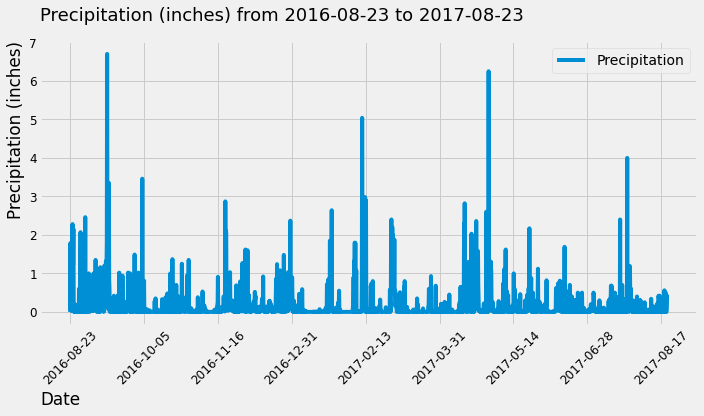

In [13]:
# RAINFALL: ALL STATIONS
precip.plot(figsize=(10,6), fontsize=12, rot=45)
plt.title(f"Precipitation (inches) from {yearago1_date} to {last_date}", fontsize=18, loc = "left", pad = 20)
plt.xlabel("Date", loc = "left")
plt.ylabel("Precipitation (inches)", loc = "top")

plt.tight_layout()
plt.savefig("Images/prcp.png")
plt.show()

In [14]:
# RAINFALL BY DATE
precip_dategrp = precip.groupby(["Date"]).sum(["Precipitation"])
precip_dategrp.head()

,Precipitation
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe().round(2)

,Precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station.id).count()
print(station_count)

9


In [39]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [measurement.station,func.count(measurement.id)]
station_grp = session.query(*sel).group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()

# IDENTIFY STATION WITH MOST MEASUREMENTS
max_station = station_grp[0][0]
print (f"The most active station is {max_station}.")

The most active station is USC00519281.


In [43]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.

low_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == max_station).scalar()
max_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == max_station).scalar()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == max_station).scalar()

print(f"Lowest temperature: {low_temp}F.")
print(f"Highest temperature: {max_temp}F.")
print(f"Average temperature: {round(avg_temp, 2)}F.")

Lowest temperature: 54.0F.
Highest temperature: 85.0F.
Average temperature: 71.66F.


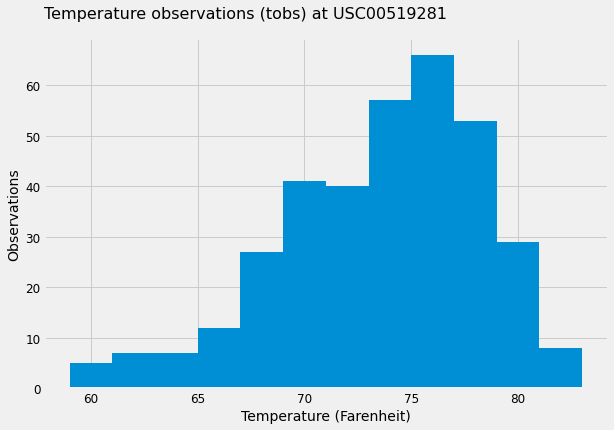

In [51]:
# Using the most active station id query the last 12 months of temperature observation
# data for this station and plot the results as a histogram

most_active_temps = pd.DataFrame(session.query(measurement.tobs).\
                                filter((measurement.station == max_station)\
                                        & (measurement.date >= yearago1_date)\
                                        & (measurement.date <= last_date)).all())

most_active_temps.plot(kind="hist", figsize=(9,6), bins=12, legend=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature (Farenheit)", fontsize=14)
plt.ylabel("Observations", fontsize=14)
plt.title(f"Temperature observations (tobs) at {max_station}", fontsize=16, loc="left", pad = 20)

plt.savefig("Images/temperatures_max_station.png")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()